# Question 1 
## Part (c)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression

In [2]:
# Import data into a pandas data frame
taxi_trips_df = pd.read_parquet('taxi_trips.parquet')
taxi_trips_df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,min_of_day,day_of_week,day_of_year
187173,0.270744,1.425051,0.466831,0.776192,-0.007192,-0.942057,-1.047619,1.180855
179655,0.085681,0.306079,-0.226274,0.124111,0.370803,0.778703,-1.047619,-0.311290
120048,-0.555533,-0.934806,-0.022489,-0.548561,-0.434735,-1.183016,-1.047619,1.316504
62587,0.069718,0.035804,0.258900,0.317284,-0.811614,-0.908008,0.481657,0.018144
212063,-0.234482,0.074616,0.115836,0.258310,0.480548,1.066806,-0.537860,0.521985


In [3]:
taxi_trips_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,min_of_day,day_of_week,day_of_year
count,5.235540e+05,5.235540e+05,5.235540e+05,5.235540e+05,5.235540e+05,5.235540e+05,5.235540e+05,5.235540e+05
mean,-1.020062e-10,-3.351633e-10,1.967263e-10,7.286158e-11,-2.623017e-10,2.331570e-10,1.387285e-08,9.326282e-10
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.336066e+01,-1.429924e+01,-3.347844e+01,-1.274645e+01,-7.062212e+00,-2.209709e+00,-1.557377e+00,-1.745299e+00
25%,-5.369088e-01,-5.731353e-01,-5.754919e-01,-5.540238e-01,-6.733706e-01,-7.168128e-01,-1.047619e+00,-8.538882e-01
50%,-1.540720e-01,7.132973e-02,-1.468923e-01,5.897350e-02,9.633706e-02,1.003516e-01,-2.810149e-02,-1.234100e-03
75%,3.703701e-01,6.306590e-01,4.286219e-01,6.097745e-01,7.129593e-01,8.389425e-01,9.914155e-01,8.514200e-01
max,2.937226e+01,1.327707e+01,5.266416e+01,2.087581e+01,4.314998e+00,1.559200e+00,1.501174e+00,1.762210e+00


From the above we can see that the data is already standardised to have a mean of 0 and a standard deviation of 1, so we don't need to pre-process the data any further.

In [4]:
# Split into features and target
# Assuming the 'trip_duration' is the target column and the other columns are features
X = taxi_trips_df.drop('trip_duration', axis=1).values
y = taxi_trips_df['trip_duration'].values.reshape(-1, 1)

# Split into training, validation, and test sets (80:10:10 split to train:test:val)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val  = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

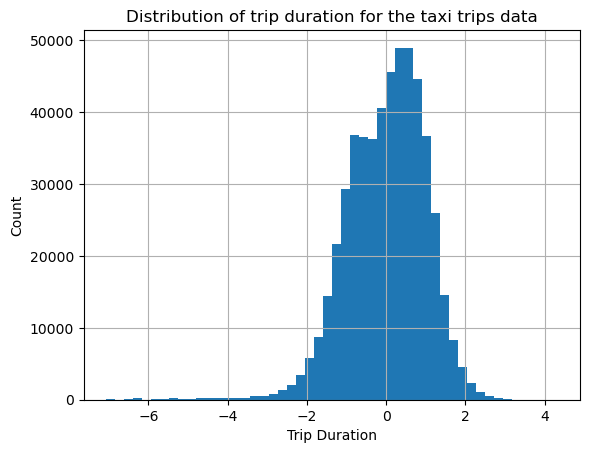

In [5]:
# Plot a distribution of the trip durations
taxi_trips_df['trip_duration'].hist(bins=50)
plt.title('Distribution of trip duration for the taxi trips data')
plt.xlabel('Trip Duration')
plt.ylabel('Count')
plt.show()

In [6]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

In [7]:
# Construct a MLP model class with 2 hidden layers
class TaxiDurationPredictor(nn.Module):
    def __init__(self, n_features, hidden_1_size, hidden_2_size, n_targets):
        """
        arguments:
        n_features: size of input
        hidden_1_size: size of hidden layer 1
        hidden_2_size: size of hidden layer 2
        n_targets: size of output
        """
        super(TaxiDurationPredictor, self).__init__()

        # Shared first layer
        self.shared_layer = nn.Sequential(
            nn.Linear(n_features, hidden_1_size),
            nn.ReLU())

        # Mean Parameters
        self.mean_layer = nn.Sequential(
            nn.Linear(hidden_1_size, hidden_2_size),
            nn.ReLU(),
            nn.Linear(hidden_2_size, 1)
        )

        # Standard Deviation Parameters
        self.std_layer = nn.Sequential(
            nn.Linear(hidden_1_size, hidden_2_size),
            nn.ReLU(),
            nn.Linear(hidden_2_size, 1),
            nn.Softplus()  # Link function for standard deviation
        )

    def forward(self, x):
        shared = self.shared_layer(x)
        mean_output = self.mean_layer(shared)
        sigma_output = self.std_layer(shared)

        
        # Convert to a distribution object
        return torch.distributions.Normal(mean_output, sigma_output)

We construct a MLP model with 2 hidden layers (of size 64 and 32 neurons respectively).

In [8]:
# Set the sizes for layers
n_features = X_train_tensor.shape[1]
hidden_1_size = 64
hidden_2_size = 32
n_targets = y_train_tensor.shape[1]

# Define the model
MLP = TaxiDurationPredictor(n_features, hidden_1_size, hidden_2_size, n_targets)
# Set the Gaussian Negative Log Likelihood Loss
criterion = nn.GaussianNLLLoss()
optimizer = optim.Adam(MLP.parameters(), lr=1e-3)

def compute_loss(model, x, y):
    normal_dist = MLP(x)
    neg_log_likelihood = -normal_dist.log_prob(y)
    return torch.mean(neg_log_likelihood)

In [9]:
# Training with validation at each epoch
num_epochs = 100
batch_size = 64
min_val_loss = np.inf

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Use dataloader for minibatches and to reshuffle the data and every epoch to reduce overfitting
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train_losses, val_losses = [], []


for i in range(num_epochs):
    batch_losses_t, batch_losses_v = [], []
    
    # training
    for batch_X, batch_y in train_loader:
        
        MLP.train()
        # Clear gradients
        optimizer.zero_grad()
        # Train model and compute the loss
        loss = compute_loss(MLP, batch_X, batch_y)
        # Back propagation
        loss.backward()
        # Update weights
        optimizer.step()
        
        # Update training loss
        batch_losses_t.append(loss.detach())

    # validation
    for batch_X, batch_y in val_loader:
        MLP.eval()
        batch_val_loss = compute_loss(MLP, batch_X, batch_y)
        batch_losses_v.append(batch_val_loss.detach())


    train_loss = np.mean(batch_losses_t)
    val_loss = np.mean(batch_losses_v)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Training / Validation at each epoch
    if i == 0 or (i+1)%10 == 0:
        print(f'Epoch {i+1}',
        f'\t\t Training Loss: {(train_loss):.5f}', 
        f'\t\t Validation Loss: {(val_loss):.5f}')

Epoch 1 		 Training Loss: 0.84536 		 Validation Loss: 0.61620
Epoch 10 		 Training Loss: 0.53845 		 Validation Loss: 0.52458
Epoch 20 		 Training Loss: 0.52046 		 Validation Loss: 0.52163
Epoch 30 		 Training Loss: 0.51116 		 Validation Loss: 0.50964
Epoch 40 		 Training Loss: 0.50726 		 Validation Loss: 0.50678
Epoch 50 		 Training Loss: 0.50253 		 Validation Loss: 0.49782
Epoch 60 		 Training Loss: 0.49851 		 Validation Loss: 0.49670
Epoch 70 		 Training Loss: 0.49522 		 Validation Loss: 0.48982
Epoch 80 		 Training Loss: 0.49307 		 Validation Loss: 0.49137
Epoch 90 		 Training Loss: 0.49121 		 Validation Loss: 0.48993
Epoch 100 		 Training Loss: 0.49033 		 Validation Loss: 0.48619


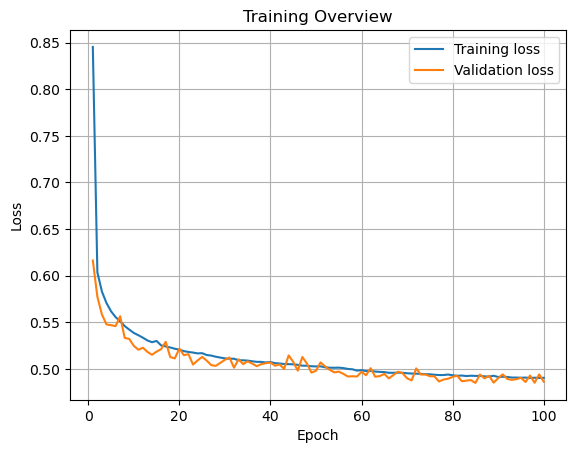

In [10]:
# Visualize the training and validation losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Overview')
plt.legend()
plt.grid()
plt.show()

As seen from above, the validation loss has not increased significantly (apart from random variations) so we can reasonably conclude that overfitting has not occured, and we can use this model to evaluate on our test set.

In [11]:
# Evaluate the model on the test set
MLP.eval()
y_dist = MLP(X_test_tensor)

# Retrieve the prediction mean and variance
test_mean = y_dist.mean
test_var = y_dist.variance

In [12]:
# Evaluate the predictions using MSE and R2 
y_true = y_test_tensor.detach().numpy().flatten()
y_pred = test_mean.detach().numpy().flatten()

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

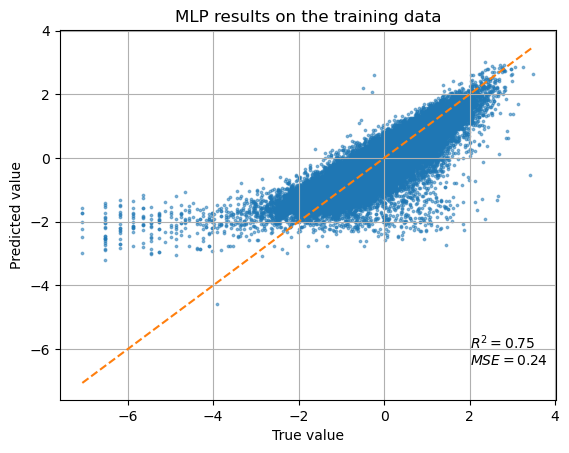

In [13]:
# Plot the results
min_val = np.amin([y_true, y_pred])
max_val = np.amax([y_true, y_pred])

plt.scatter(y_true, y_pred, alpha=0.5, s=3)
plt.plot(np.linspace(min_val, max_val), np.linspace(min_val, max_val), '--', color="C1")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.title("MLP results on the training data")
plt.text(2, -6, f'$R^2 = {r2:.2f}$')
plt.text(2, -6.5, f'$MSE = {mse:.2f}$')
plt.grid()
plt.show()

Now we can compare our MLP model to a baseline linear regression model to ensure that it beats it.

In [14]:
# Use a linear regression model from sklearn
baseline_model = LinearRegression()

# Train the baseline model
baseline_model.fit(X_train, y_train)

# Predict using the baseline model
baseline_predictions = baseline_model.predict(X_test)

# Calculate the baseline mean squared error
baseline_R2 = r2_score(y_test, baseline_predictions)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
print(f"Baseline R2 Score: {baseline_R2:.4f}")
print(f"Baseline Mean Squared Error: {baseline_mse:.4f}")

Baseline R2 Score: 0.0169
Baseline Mean Squared Error: 0.9775


Thus we observe that our MLP model has a:
- larger $R^2$ score (which suggests that the initial model better explains the variation around the mean),
- lower mean squared error (which suggests that our model is more accurate).

So we can conclude that this model beats our baseline simple linear regression model, and is appropriate to use in this case.

---
We can also examine the distribution of the mean and variance on the test set:

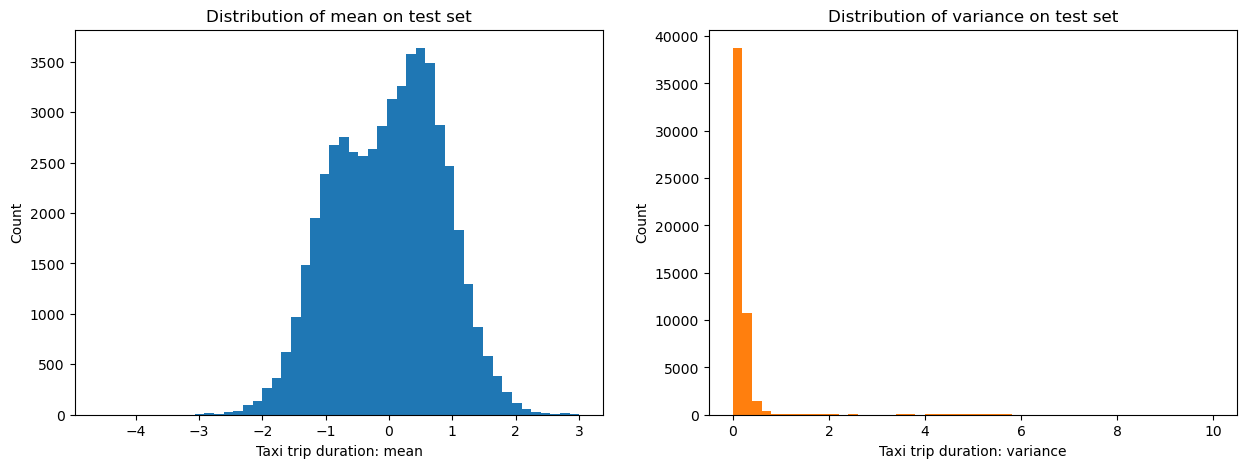

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
colors = ["C0", "C1"]
labels = ["mean", "variance"]
data = [test_mean, test_var]
ranges = [None, (0, 10)]
n_bins = 50

for i, ax in enumerate(axes):
    x = data[i].detach().numpy()
    ax.hist(x, bins=n_bins, color=colors[i], range=ranges[i])
    ax.set_xlabel(f"Taxi trip duration: {labels[i]}")
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {labels[i]} on test set")

plt.show()

## Part (d)

We trained our model using the assumption $Y|X \sim \mathcal{N} (f_\mu(X), f_\sigma(X)^2)$.

So once we have our estimates for $f_\mu(X)$ and $f_\sigma(X)$, we can use the cdf (or the integral of the normal pdf) with these parameters get the desired estimate:

$$
P(Y|X < 45) = \int_{-\infty}^{45} \frac{1}{f_\sigma\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{Y - f_\mu}{f_\sigma}\right)^2} dy
$$

Note that as the data provided was already standardised, we do not know what the actual ranges for each feature / target is.  
So it is unclear what 45 minutes converts to when standardised in the same way as the data.

Further, in pytorch, when defining the model, we used the PyTorch distributions package, specifically `torch.distributions.Normal`.  
Thus we do not need to explicitly construct the pdf and integrate, but we can already use the built in cdf method with the distribution from our trained model.

## Part (e)

Again it is important to note that we do not know what 45 minutes corresponds to in the already standardised dataset, so I will examine the probability $P(Y|X < 0.675)$.  
Unless we have the original unstandardised data, we are not sure what time this corresponds to.  
(Note this is the value of the 3rd for the standard normal distribution, so we can reasonably approximately 75% of our held out test points to be in this range)

In [16]:
threshold = 0.675
threshold_val = torch.Tensor([threshold])

# Evaluate the dstribution on the test set
MLP.eval()
y_dist = MLP(X_test_tensor)

# Compute the probabilities that each test point is less than the threshold duration
cdf_probabilities = y_dist.cdf(threshold_val).detach().numpy().flatten()

# Convert probabilities to binary labels (1 if probability > 0.5, 0 otherwise)
predicted_labels = (cdf_probabilities > 0.5).astype(int)

# Evaluate fraction of samples in test set
ratio = np.sum(predicted_labels) / len(predicted_labels)
print(f"Percentage of predicted test samples with duration < {threshold} is: {ratio*100:.2f}%")

Percentage of predicted test samples with duration < 0.675 is: 77.08%


In [17]:
# Convert the true trip duration times in the test set to binary labels
true_labels = (y_test < threshold).astype(int).flatten()

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy of predictions of probabilities on the test set: {accuracy * 100:.2f}%")

Accuracy of predictions of probabilities on the test set: 89.20%


So we observe that the under the normal distribution assumption when training the model, we get an acceptable accuracy score when predicting the probabilities for trip durations on the held out test set.